# Setup

In [1]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/GitHub/INM363-Project'

In [2]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update &> /dev/null


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip &> /dev/null

# Boost libraries
apt-get install libboost-all-dev &> /dev/null


In [3]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

In [4]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [5]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import src.helper_fuctions as helper
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np
sns.set()

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Initialize Ray

In [7]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-28 20:55:58,349	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# ICM 

In [8]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False
config['in_evaluation'] = True

config["num_workers"] = 0 

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
#config["vf_clip_param"] = 400
icm_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

2022-09-28 20:55:58,931	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-28 20:55:58,934	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,
2022-09-28 20:55:59,287	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-28 20:56:03,952	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [9]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [10]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

#chkpt_mean_rewards = [] 
#chkpt_me

icm_chkpt_mean_rewards = np.array([]) 
icm_chkpt_std_rewards = np.array([]) 
icm_chkpt_mean_steps = np.array([]) 
icm_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  icm_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 500# 200

    for step in range(n_step):
          action = icm_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  icm_chkpt_mean_rewards = np.append(icm_chkpt_mean_rewards, np.mean(total_reward) )
  icm_chkpt_std_rewards = np.append(icm_chkpt_std_rewards, np.std(total_reward))
  icm_chkpt_mean_steps = np.append(icm_chkpt_mean_steps, np.mean(total_steps))
  icm_chkpt_std_steps = np.append(icm_chkpt_std_steps, np.std(total_steps))



2022-09-28 20:56:04,424	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000801
2022-09-28 20:56:04,425	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 801, '_timesteps_total': None, '_time_total': 60853.55896234512, '_episodes_total': 9032}
2022-09-28 20:56:04,430	WARNING deprecation.py:48 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Total number of checkpoints:  26
checkpoint_000801


2022-09-28 20:56:12,250	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000820
2022-09-28 20:56:12,252	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 61773.92656135559, '_episodes_total': 9468}


checkpoint_000820


2022-09-28 20:56:19,944	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000840
2022-09-28 20:56:19,946	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 62746.529547691345, '_episodes_total': 9927}


checkpoint_000840


2022-09-28 20:56:27,518	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000860
2022-09-28 20:56:27,520	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 63713.420481443405, '_episodes_total': 10365}


checkpoint_000860


2022-09-28 20:56:35,210	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000880
2022-09-28 20:56:35,211	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 64691.78292346001, '_episodes_total': 10815}


checkpoint_000880


2022-09-28 20:56:42,935	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000900
2022-09-28 20:56:42,936	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 65662.23680830002, '_episodes_total': 11274}


checkpoint_000900


2022-09-28 20:56:50,567	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000920
2022-09-28 20:56:50,569	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 66629.68229079247, '_episodes_total': 11713}


checkpoint_000920


2022-09-28 20:56:58,209	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000940
2022-09-28 20:56:58,212	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 67612.77046179771, '_episodes_total': 12158}


checkpoint_000940


2022-09-28 20:57:05,876	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000960
2022-09-28 20:57:05,877	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 68585.41779780388, '_episodes_total': 12604}


checkpoint_000960


2022-09-28 20:57:13,567	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_000980
2022-09-28 20:57:13,569	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 69549.05559277534, '_episodes_total': 13049}


checkpoint_000980


2022-09-28 20:57:21,206	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001000
2022-09-28 20:57:21,207	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 70516.29712486267, '_episodes_total': 13491}


checkpoint_001000


2022-09-28 20:57:28,751	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001020
2022-09-28 20:57:28,752	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1020, '_timesteps_total': None, '_time_total': 71483.10817933083, '_episodes_total': 13943}


checkpoint_001020


2022-09-28 20:57:36,284	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001040
2022-09-28 20:57:36,285	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1040, '_timesteps_total': None, '_time_total': 72444.58446025848, '_episodes_total': 14395}


checkpoint_001040


2022-09-28 20:57:43,872	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001060
2022-09-28 20:57:43,873	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1060, '_timesteps_total': None, '_time_total': 73399.71960067749, '_episodes_total': 14845}


checkpoint_001060


2022-09-28 20:57:51,492	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001080
2022-09-28 20:57:51,493	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1080, '_timesteps_total': None, '_time_total': 74339.59455227852, '_episodes_total': 15283}


checkpoint_001080


2022-09-28 20:57:59,140	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001100
2022-09-28 20:57:59,141	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1100, '_timesteps_total': None, '_time_total': 75290.79979395866, '_episodes_total': 15726}


checkpoint_001100


2022-09-28 20:58:06,792	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001130
2022-09-28 20:58:06,794	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1130, '_timesteps_total': None, '_time_total': 76603.28496217728, '_episodes_total': 16403}


checkpoint_001130


2022-09-28 20:58:14,558	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001160
2022-09-28 20:58:14,559	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1160, '_timesteps_total': None, '_time_total': 77913.4022500515, '_episodes_total': 17070}


checkpoint_001160


2022-09-28 20:58:22,175	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001190
2022-09-28 20:58:22,177	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1190, '_timesteps_total': None, '_time_total': 79232.74665427208, '_episodes_total': 17739}


checkpoint_001190


2022-09-28 20:58:29,795	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001220
2022-09-28 20:58:29,797	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1220, '_timesteps_total': None, '_time_total': 80545.7797756195, '_episodes_total': 18397}


checkpoint_001220


2022-09-28 20:58:37,402	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001250
2022-09-28 20:58:37,403	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1250, '_timesteps_total': None, '_time_total': 81857.14853620529, '_episodes_total': 19060}


checkpoint_001250


2022-09-28 20:58:45,081	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001280
2022-09-28 20:58:45,083	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1280, '_timesteps_total': None, '_time_total': 83177.69215011597, '_episodes_total': 19749}


checkpoint_001280


2022-09-28 20:58:52,839	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001310
2022-09-28 20:58:52,840	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1310, '_timesteps_total': None, '_time_total': 84490.25958061218, '_episodes_total': 20420}


checkpoint_001310


2022-09-28 20:59:00,471	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001340
2022-09-28 20:59:00,472	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1340, '_timesteps_total': None, '_time_total': 85803.04284977913, '_episodes_total': 21078}


checkpoint_001340


2022-09-28 20:59:08,140	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001370
2022-09-28 20:59:08,142	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1370, '_timesteps_total': None, '_time_total': 87123.86500430107, '_episodes_total': 21753}


checkpoint_001370


2022-09-28 20:59:15,764	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001400
2022-09-28 20:59:15,766	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1400, '_timesteps_total': None, '_time_total': 88437.56133937836, '_episodes_total': 22412}


checkpoint_001400


In [11]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
icm_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
icm_df['eps_cumsum'] = icm_df['episodes_this_iter'].cumsum()
icm_df = icm_df[['checkpoint', 'eps_cumsum']]
icm_df.checkpoint = icm_df['checkpoint'].astype(int)
icm_df.head()

,checkpoint,eps_cumsum
0,1,23.0
1,2,44.0
2,3,66.0
3,4,87.0
4,5,110.0


In [12]:
icm_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  #print(chkpt_int)
  eps_num = icm_df[~(icm_df['eps_cumsum'].where((800+icm_df['checkpoint']) == chkpt_int)).isna()].eps_cumsum.values[0]
  icm_cum_eps.append(eps_num)

print(f"Total episodes: {icm_cum_eps}")
print(f"Mean reward: {icm_chkpt_mean_rewards}")
print(f"Std reward: {icm_chkpt_std_rewards}")
print(f"Mean steps: {icm_chkpt_mean_steps}")
print(f"Std steps: {icm_chkpt_std_steps}")

#check length of lists are the same 
#assert len(icm_cum_eps) == len(icm_chkpt_mean_rewards)
#assert len(icm_cum_eps) == len(icm_chkpt_mean_steps)

Total episodes: [23.0, 459.0, 918.0, 1356.0, 1806.0, 2265.0, 2704.0, 3149.0, 3595.0, 4040.0, 4482.0, 4934.0, 5386.0, 5836.0, 6274.0, 6717.0, 7394.0, 8061.0, 8730.0, 9388.0, 10051.0, 10740.0, 11411.0, 12069.0, 12744.0, 13403.0]
Mean reward: [4.  4.  3.8 4.  4.7 4.  5.  5.  5.  5.  5.  4.  5.  4.  4.8 4.  4.  2.
 3.  5.  4.  4.  5.  6.  5.  6. ]
Std reward: [0.         0.         0.9797959  0.         0.45825757 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.4        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Mean steps: [200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.]
Std steps: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM avg reward

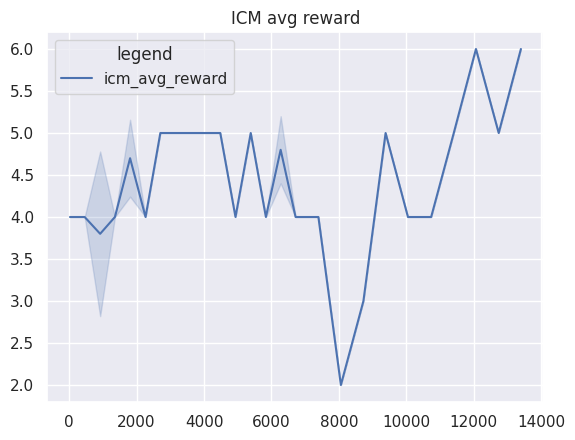

In [13]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'b-', label='icm_avg_reward')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), 
                 (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()



## ICM avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


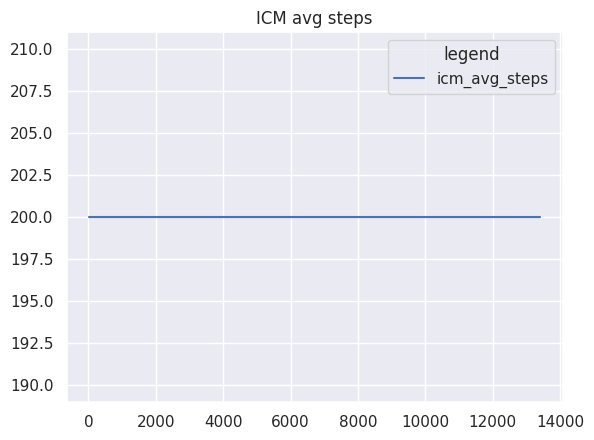

In [14]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'b-', label='icm_avg_steps')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), 
                 (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg steps") 
plt.show()



## ICM shortest Path

In [59]:
#max_mean_rewards_idx = np.argmax(icm_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(icm_chkpt_mean_steps)

eps_itr = icm_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = icm_df[~(icm_df["eps_cumsum"].where(icm_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

23.0
Best checkpoint:  1


In [66]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern" 
chkpt_dir = "checkpoint_00" + str((600+800)) #str(best_chkpt+800)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001400'

In [67]:
icm_agent.restore(chkpt_pth)

2022-09-28 21:29:45,080	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense_new_pattern/checkpoint_001400
2022-09-28 21:29:45,082	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1400, '_timesteps_total': None, '_time_total': 88437.56133937836, '_episodes_total': 22412}


cumulative reward 6.0
total steps: 199
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
Health Bonus locations: [(-704.0, 96.0), (-544.0, 224.0), (-544.0, -128.0), (-608.0, 96.0), (-544.0, 64.0), (-544.0, 128.0), (-544.0, -32.0), (-544.0, 320.0), (-544.0, 384.0), (-800.0, 96.0), (-896.0, 96.0)]
Armor location: [(-544.0, -192.0)]
Sector locations: [(-672.0, -736.0, 32.0, 32.0), (-736.0, -672.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-672.0, -672.0, -256.0, -64.0), (-416.0, -672.0, -256.0, -256.0), (-416.0, -416.0, -64.0, -256.0), (-672.0, -608.0, -64.0, -64.0), (-480.0, -416.0, -64.0, -64.0), (-672.0, -672.0, 0.0, 32.0), (-416.0, -480.0, 0.0, 0.0), (-672.0, -672.0, 160.0, 192.0), (-608.0, -672.0, 0.0, 0.0), (-416.0, -416.0, 192.0, 0.0), (-672.0, -608.0, 192.0, 192.0), (-480.0, -41

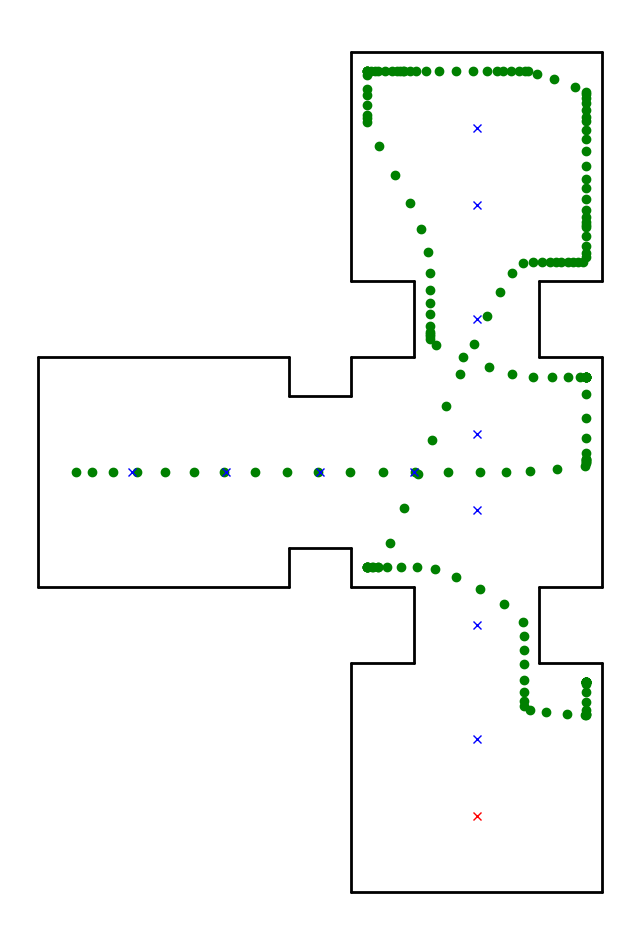

In [68]:
state = env.reset()
sum_reward = 0
n_step = 200
icm_path = [] 

for step in range(n_step):
    action = icm_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      icm_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/test/dense_new_pattern_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, icm_path)


## ICM Goal Accomplishment

In [69]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200
    counter = 0 

    for step in range(n_step):
        action = icm_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
        counter +=1
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 0 / 100


# RE3

In [22]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [23]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['explore'] = False 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
re3_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=12196) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=12196) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
(RolloutWorker pid=12196) episode timeout: 800
(RolloutWorker pid=12196) screen resolution: 320X240
(RolloutWorker pid=12197) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=12197) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
(RolloutWorker pid=12197) episode timeout: 800
(RolloutWorker pid=12197) screen resolution: 320X240


(RolloutWorker pid=12197) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=12197)   "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
(RolloutWorker pid=12196) 2022-09-28 21:01:04,470	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=12196) /usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
(RolloutWorker pid=12196)   "Function `env.seed(seed)` is marked as deprecated and will be remove

created agent


In [24]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [25]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


re3_chkpt_mean_rewards = np.array([]) 
re3_chkpt_std_rewards = np.array([]) 
re3_chkpt_mean_steps = np.array([]) 
re3_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  re3_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = re3_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  re3_chkpt_mean_rewards = np.append(re3_chkpt_mean_rewards, np.mean(total_reward) )
  re3_chkpt_std_rewards = np.append(re3_chkpt_std_rewards, np.std(total_reward))
  re3_chkpt_mean_steps = np.append(re3_chkpt_mean_steps, np.mean(total_steps))
  re3_chkpt_std_steps = np.append(re3_chkpt_std_steps, np.std(total_steps))



2022-09-28 21:01:10,098	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000801
2022-09-28 21:01:10,099	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 801, '_timesteps_total': None, '_time_total': 41997.79214978218, '_episodes_total': 9384}


Total number of checkpoints:  16
checkpoint_000801


2022-09-28 21:01:17,309	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000820
2022-09-28 21:01:17,310	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 42905.456568956375, '_episodes_total': 10232}


checkpoint_000820


2022-09-28 21:01:24,302	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000840
2022-09-28 21:01:24,304	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 43859.628034353256, '_episodes_total': 11156}


checkpoint_000840


2022-09-28 21:01:30,976	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000860
2022-09-28 21:01:30,978	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 44824.26739525795, '_episodes_total': 12042}


checkpoint_000860


2022-09-28 21:01:37,991	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000880
2022-09-28 21:01:37,993	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 45798.20497393608, '_episodes_total': 12938}


checkpoint_000880


2022-09-28 21:01:44,969	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000900
2022-09-28 21:01:44,970	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 46764.401656627655, '_episodes_total': 13854}


checkpoint_000900


2022-09-28 21:01:52,035	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000920
2022-09-28 21:01:52,037	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 47738.645857810974, '_episodes_total': 14799}


checkpoint_000920


2022-09-28 21:01:58,952	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000940
2022-09-28 21:01:58,954	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 48685.18894457817, '_episodes_total': 15764}


checkpoint_000940
checkpoint_000960


2022-09-28 21:02:05,045	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000960
2022-09-28 21:02:05,047	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 49634.03314328194, '_episodes_total': 16774}


checkpoint_000980


2022-09-28 21:02:12,956	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_000980
2022-09-28 21:02:12,958	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 50588.63750243187, '_episodes_total': 17801}


checkpoint_001000


2022-09-28 21:02:15,683	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001000
2022-09-28 21:02:15,685	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 51538.59438037872, '_episodes_total': 18893}


checkpoint_001020


2022-09-28 21:02:18,300	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001020
2022-09-28 21:02:18,301	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1020, '_timesteps_total': None, '_time_total': 52468.55801200867, '_episodes_total': 20087}


checkpoint_001040


2022-09-28 21:02:25,981	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001040
2022-09-28 21:02:25,983	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1040, '_timesteps_total': None, '_time_total': 53385.68236327171, '_episodes_total': 21336}


checkpoint_001060


2022-09-28 21:02:30,116	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001060
2022-09-28 21:02:30,117	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1060, '_timesteps_total': None, '_time_total': 54314.54844093323, '_episodes_total': 22577}


checkpoint_001080


2022-09-28 21:02:32,369	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001080
2022-09-28 21:02:32,371	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1080, '_timesteps_total': None, '_time_total': 55243.90162444115, '_episodes_total': 23848}


checkpoint_001100


2022-09-28 21:02:35,269	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001100
2022-09-28 21:02:35,270	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1100, '_timesteps_total': None, '_time_total': 56172.3584549427, '_episodes_total': 25067}


In [26]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
re3_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
re3_df['eps_cumsum'] = re3_df['episodes_this_iter'].cumsum()
re3_df = re3_df[['checkpoint', 'eps_cumsum']]
re3_df.checkpoint = re3_df['checkpoint'].astype(int)
re3_df.tail()

,checkpoint,eps_cumsum
295,296,15486.0
296,297,15548.0
297,298,15612.0
298,299,15671.0
299,300,15740.0


In [53]:
re3_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = re3_df[~(re3_df['eps_cumsum'].where((re3_df['checkpoint']+800) == chkpt_int)).isna()].eps_cumsum.values[0]
  re3_cum_eps.append(eps_num)

print(f"Total episodes: {re3_cum_eps}")
print(f"Mean reward: {re3_chkpt_mean_rewards}")
print(f"Std reward: {re3_chkpt_std_rewards}")
print(f"Mean steps: {re3_chkpt_mean_steps}")
print(f"Std steps: {re3_chkpt_std_steps}")

#check length of lists are the same 
assert len(re3_cum_eps) == len(re3_chkpt_mean_rewards)
assert len(re3_cum_eps) == len(re3_chkpt_mean_steps)

Total episodes: [57.0, 905.0, 1829.0, 2715.0, 3611.0, 4527.0, 5472.0, 6437.0, 7447.0, 8474.0, 9566.0, 10760.0, 12009.0, 13250.0, 14521.0, 15740.0]
Mean reward: [ 0.   1.   5.8  4.4  4.   3.6  4.4  8.9  2.  14.  15.   2.  11.5 15.9
 15.  14.7]
Std reward: [0.         0.         3.09192497 1.2        0.         0.8
 0.48989795 4.98898787 0.         0.         0.         0.
 6.87386354 0.3        0.         0.45825757]
Mean steps: [200.  200.  189.3 200.  200.  200.  200.  144.4 200.   50.   40.  200.
  91.5  36.3  53.9  48.1]
Std steps: [ 0.          0.         32.1         0.          0.          0.
  0.         68.09581485  0.          0.          0.          0.
 71.02992327  0.9         1.37477271  2.7       ]


## RE3 avg reward

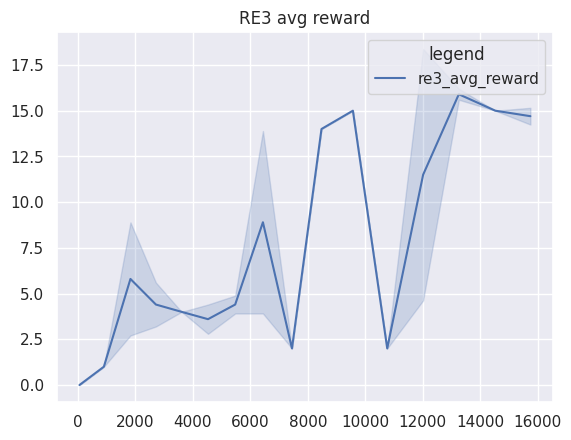

In [28]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='re3_avg_reward')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg reward") 
plt.show()



## RE3 avg steps

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


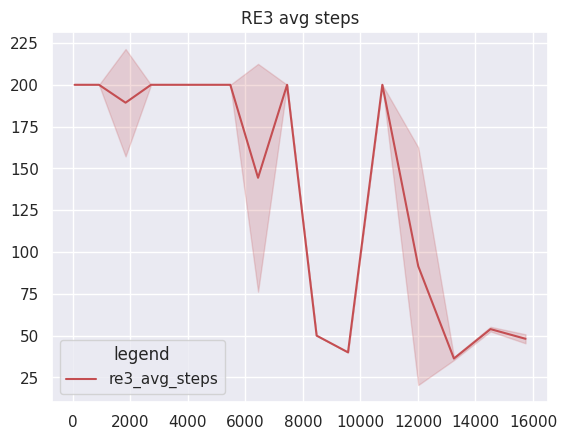

In [29]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'r-', label='re3_avg_steps')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='r', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg steps") 
plt.show()



## RE3 Path

In [49]:
#max_mean_rewards_idx = np.argmax(re3_chkpt_mean_rewards)
max_mean_rewards_idx = np.argmin(re3_chkpt_mean_steps)
eps_itr = re3_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = re3_df[~(re3_df["eps_cumsum"].where(re3_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[-1]
print("Best checkpoint: ", best_chkpt)

13250.0
Best checkpoint:  260


In [50]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern" 
chkpt_dir = "checkpoint_00" + str(best_chkpt+800)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001060'

In [51]:
re3_agent.restore(chkpt_pth)

2022-09-28 21:22:03,215	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense_new_pattern/checkpoint_001060
2022-09-28 21:22:03,217	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1060, '_timesteps_total': None, '_time_total': 54314.54844093323, '_episodes_total': 22577}


cumulative reward 15.0
total steps: 34
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/dense_new_pattern_fixed_start.wad
Health Bonus locations: [(-704.0, 96.0), (-544.0, 224.0), (-544.0, -128.0), (-608.0, 96.0), (-544.0, 64.0), (-544.0, 128.0), (-544.0, -32.0), (-544.0, 320.0), (-544.0, 384.0), (-800.0, 96.0), (-896.0, 96.0)]
Armor location: [(-544.0, -192.0)]
Sector locations: [(-672.0, -736.0, 32.0, 32.0), (-736.0, -672.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-672.0, -672.0, -256.0, -64.0), (-416.0, -672.0, -256.0, -256.0), (-416.0, -416.0, -64.0, -256.0), (-672.0, -608.0, -64.0, -64.0), (-480.0, -416.0, -64.0, -64.0), (-672.0, -672.0, 0.0, 32.0), (-416.0, -480.0, 0.0, 0.0), (-672.0, -672.0, 160.0, 192.0), (-608.0, -672.0, 0.0, 0.0), (-416.0, -416.0, 192.0, 0.0), (-672.0, -608.0, 192.0, 192.0), (-480.0, -41

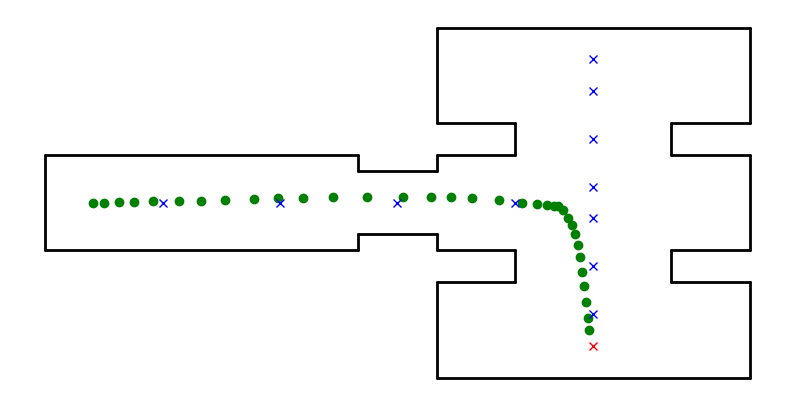

In [55]:
state = env.reset()
sum_reward = 0
n_step = 200
re3_path = [] 

for step in range(n_step):
    action = re3_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      re3_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/test/dense_new_pattern_fixed_start.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, re3_path)


## RE3 Goal Accomplishment

In [56]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200
    counter = 0 

    for step in range(n_step):
        action = re3_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
        counter += 1
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 100 / 100


# All graphs

## All Paths

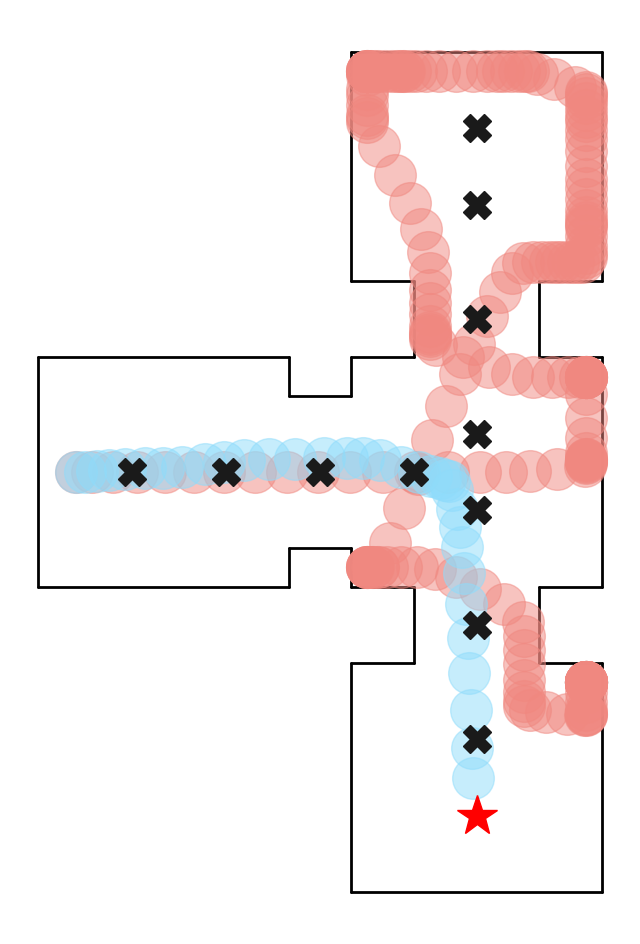

In [70]:
plt.rcParams["figure.figsize"] = (8, 12)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

# plot path taken
#for pos in ppo_path:
#    plt.plot(pos[0], pos[1], color='#B5E7B5', marker='o', markersize = 30, alpha = 0.5)
for pos in icm_path:
    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 30, alpha = 0.5)
for pos in re3_path:
    plt.plot(pos[0], pos[1], color='#8FDCFB', marker='o', markersize=30, alpha = 0.5)

#'#2E75B6'
    

# plot positions of health bonus and armor:
for pos in health_pos:
    plt.plot(pos[0], pos[1], color='k', marker='X', markersize = 20)
for pos in armor_pos:
    plt.plot(pos[0], pos[1], color='red', marker='*', markersize = 30)

plt.axis("off")
plt.show()


## Average Reward

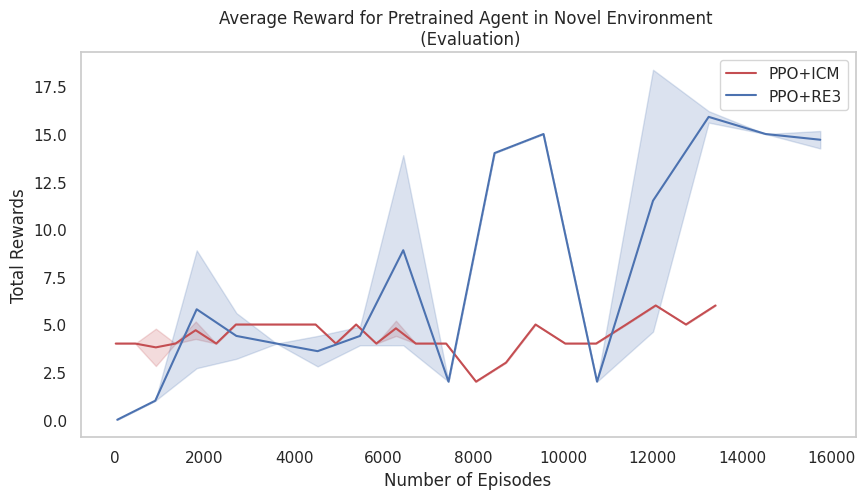

In [43]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})
#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 


plt.legend() #title='legend'
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.title("Average Reward for Pretrained Agent in Novel Environment \n (Evaluation)") 
plt.show()


## Average Steps

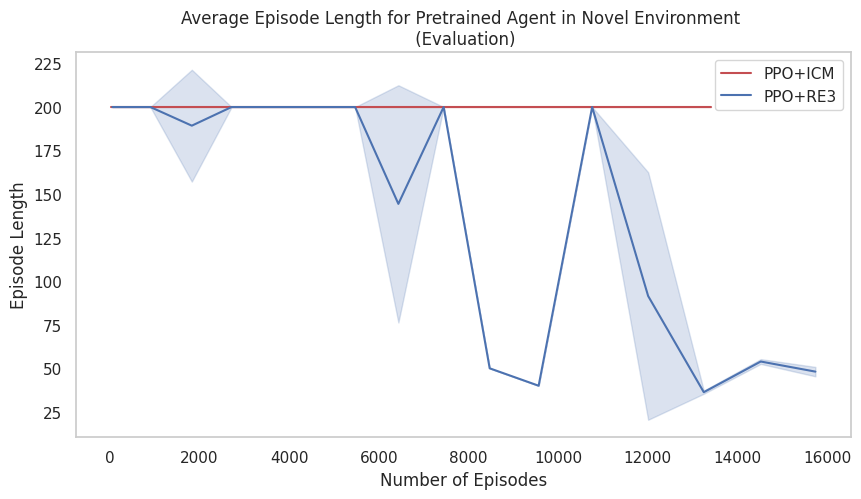

In [44]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set_style("whitegrid", {'axes.grid' : False})

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend()
plt.title("Average Episode Length for Pretrained Agent in Novel Environment \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.show()

# Save results file

In [38]:
from pathlib import Path 
root = "/content/drive/MyDrive/GitHub/INM363-Project/results" 
cols = ["episodes", "mean_reward", "std_reward", "mean_steps", "std_steps"]

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## ICM

In [39]:
fname = "/E3_icm_dense_new_pattern.csv"

df_icm = pd.DataFrame(columns = cols)
df_icm["episodes"] = icm_cum_eps
df_icm["mean_reward"] = icm_chkpt_mean_rewards
df_icm["std_reward"] = icm_chkpt_std_rewards
df_icm["mean_steps"] = icm_chkpt_mean_steps
df_icm["std_steps"] = icm_chkpt_std_steps

fpath = Path(root + fname)
df_icm.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_icm.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E3_icm_dense_new_pattern.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,23.0,4.0,0.000000,200.0,0.0
1,459.0,4.0,0.000000,200.0,0.0
2,918.0,3.8,0.979796,200.0,0.0
3,1356.0,4.0,0.000000,200.0,0.0
4,1806.0,4.7,0.458258,200.0,0.0


## RE3

In [40]:
fname = "/E3_re3_dense_new_pattern.csv"

df_re3 = pd.DataFrame(columns = cols)
df_re3["episodes"] = re3_cum_eps
df_re3["mean_reward"] = re3_chkpt_mean_rewards
df_re3["std_reward"] = re3_chkpt_std_rewards
df_re3["mean_steps"] = re3_chkpt_mean_steps
df_re3["std_steps"] = re3_chkpt_std_steps

fpath = Path(root + fname)
df_re3.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_re3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E3_re3_dense_new_pattern.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,57.0,0.0,0.000000,200.0,0.0
1,905.0,1.0,0.000000,200.0,0.0
2,1829.0,5.8,3.091925,189.3,32.1
3,2715.0,4.4,1.200000,200.0,0.0
4,3611.0,4.0,0.000000,200.0,0.0
